In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

# Running functions_bar_igw.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_borrador/IGW_BAR/functions_bar_igw.ipynb

In [2]:
path_to_mask = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60/1_mesh_mask_TROPICO12_L125_tr21.nc" # in numpy .npy format
path_to_input = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_hf/ssh_hf_" # including the file name prefix 
path_to_save = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_bar/" # including the file name prefix 

ssh_hf = xr.open_mfdataset(path_to_input + "02.nc")
#ds = ssh_hf.rename({'__xarray_dataarray_variable__': 'ssh_hf'}).sel(time_counter=pd.to_datetime('2014-02-01T11:30:00')).load()
ds = ssh_hf.sel(time_counter=pd.to_datetime('2014-02-01T11:30:00')).load()
mask = xr.open_dataset(path_to_mask,drop_variables={"x","y"}) 
mask = mask.tmaskutil[0,:,:].values

In [3]:
ssh_hf = ds.ssh_hf.where(mask==1,np.nan) # change false by 1, otherwise everithing is nan
ssh_hf = ssh_hf.coarsen(x=4, y=4, boundary='trim').mean()

x_axis = Axis(ssh_hf.x.values,is_circle=True)
y_axis = Axis(ssh_hf.y.values,is_circle=True)
grid = Grid2D(y_axis, x_axis, ssh_hf.values.transpose(0,1))

has_converged, filled = fill.gauss_seidel(grid) 
ssh_hf_filled = ssh_hf.copy(deep=True,data=filled) 

In [4]:
dx = 10 # in kilometers
ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_hf_filled.lat[:,0].values,
                                                         ssh_hf_filled.lon[0,:].values,
                                                         dx)

In [5]:
# Create a new DataArray with the filled data
ssh_hf_filled = xr.DataArray(
    data=filled,
    dims=['y', 'x'],
    coords={'y': ssh_hf.y, 'x': ssh_hf.x, 'lat': (['y', 'x'], ssh_hf.lat.data), 'lon': (['y', 'x'], ssh_hf.lon.data)}
)

ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_hf_filled.lat[:, 0].values,
                                                         ssh_hf_filled.lon[0, :].values,
                                                         dx)

ENSLAT2D_flat = ENSLAT2D.flatten()
ENSLON2D_flat = ENSLON2D.flatten()

points = np.column_stack((ssh_hf_filled.lat.data.flatten(), ssh_hf_filled.lon.data.flatten()))
values = ssh_hf_filled.data.flatten()
target_grid = np.column_stack((ENSLAT2D_flat, ENSLON2D_flat))

array_cart_ssh = griddata(points, values, target_grid, method='linear')

array_cart_ssh = array_cart_ssh.reshape(ENSLAT2D.shape)

In [16]:
print(array_cart_ssh.shape)

(160, 162)


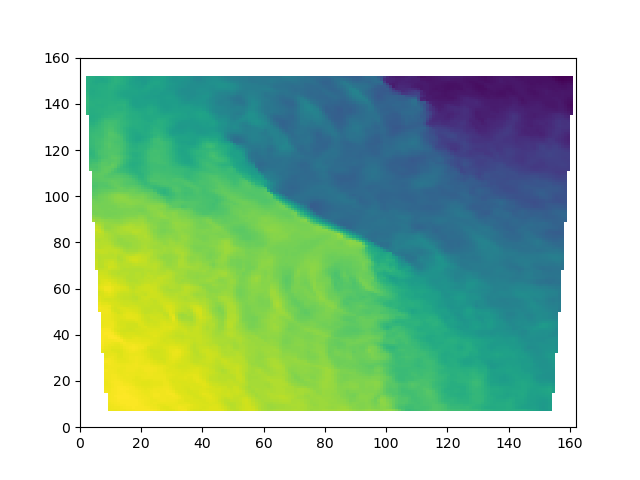

In [15]:
plt.figure()
plt.pcolormesh(array_cart_ssh)
plt.show()

In [14]:
#INTERPOLATION OF NaNs # 
x_axis = Axis(np.arange(i_lon))
y_axis = Axis(np.arange(i_lat))
    
grid = Grid2D(y_axis, x_axis, array_cart_ssh.reshape((i_lat,i_lon)))
has_converged, filled = fill.gauss_seidel(grid)

mask_cart = np.isnan(array_cart_ssh.reshape((i_lat,i_lon)))

cart_ssh_hf = xr.DataArray(data=filled,
                           dims=["y","x"],
                           coords = dict(y=(["y"],np.arange(i_lat)), x=(["x"],np.arange(i_lon))
                         ))

In [7]:
# EXTRACTING BAROTROPIC TIDE # 
cart_ssh_filtered = np.array(extract_bar_tide(cart_ssh_hf.values, dx))

In [8]:
#lon2d, lat2d = np.meshgrid(ssh_hf.lon.values, ssh_hf.lat.values)
lon2d, lat2d = np.meshgrid(ssh_hf.lon[0,:].values, ssh_hf.lat[:,0].values)

In [9]:
ssh_bar_array = np.array([griddata(
    np.array([ENSLAT2D.flatten(), ENSLON2D.flatten()]).T,  
    cart_ssh_filtered.flatten(),                        
    (lat2d, lon2d),                                       
    method='linear'                                         
)])

# Creating the ssh_bar DataArray
ssh_bar = xr.DataArray(
    data=ssh_bar_array[0],
    dims=ssh_hf.dims,
    coords=ssh_hf.coords
)

In [10]:
ssh_bar

<xarray.DataArray (y: 213, x: 197)> Size: 336kB
array([[ 0.76771547,  0.76804352,  0.76834517, ...,  0.21116283,
         0.20852343,  0.20605217],
       [ 0.76796994,  0.7682537 ,  0.76850224, ...,  0.21010851,
         0.20747806,  0.20502709],
       [ 0.76819017,  0.76843155,  0.76864527, ...,  0.20899584,
         0.20637175,  0.2039417 ],
       ...,
       [ 0.28482566,  0.28437433,  0.28360655, ..., -0.52480624,
        -0.52528867, -0.52543468],
       [ 0.28328424,  0.28283752,  0.28207436, ..., -0.52792797,
        -0.5283926 , -0.52851353],
       [ 0.28187605,  0.2814325 ,  0.28066413, ..., -0.53071866,
        -0.531168  , -0.53125689]])
Coordinates:
    lat           (y, x) float32 168kB -28.78 -28.78 -28.78 ... -15.74 -15.74
    lon           (y, x) float32 168kB 159.3 159.3 159.4 ... 172.2 172.3 172.3
    time_counter  datetime64[ns] 8B 2014-02-01T11:30:00
Dimensions without coordinates: y, x

In [11]:
ssh_igw = ssh_hf_filled - ssh_bar

/tmp/ipykernel_2030721/46507011.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_bar.lon, ssh_bar.lat, ssh_igw)


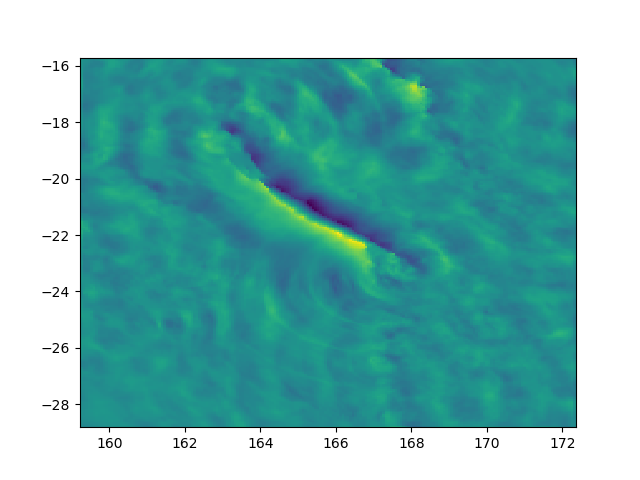

In [12]:
plt.figure()
plt.pcolormesh(ssh_bar.lon, ssh_bar.lat, ssh_igw)
plt.show()

Re interpolando

In [13]:
ssh_bar

<xarray.DataArray (y: 213, x: 197)> Size: 336kB
array([[ 0.76771547,  0.76804352,  0.76834517, ...,  0.21116283,
         0.20852343,  0.20605217],
       [ 0.76796994,  0.7682537 ,  0.76850224, ...,  0.21010851,
         0.20747806,  0.20502709],
       [ 0.76819017,  0.76843155,  0.76864527, ...,  0.20899584,
         0.20637175,  0.2039417 ],
       ...,
       [ 0.28482566,  0.28437433,  0.28360655, ..., -0.52480624,
        -0.52528867, -0.52543468],
       [ 0.28328424,  0.28283752,  0.28207436, ..., -0.52792797,
        -0.5283926 , -0.52851353],
       [ 0.28187605,  0.2814325 ,  0.28066413, ..., -0.53071866,
        -0.531168  , -0.53125689]])
Coordinates:
    lat           (y, x) float32 168kB -28.78 -28.78 -28.78 ... -15.74 -15.74
    lon           (y, x) float32 168kB 159.3 159.3 159.4 ... 172.2 172.3 172.3
    time_counter  datetime64[ns] 8B 2014-02-01T11:30:00
Dimensions without coordinates: y, x

In [14]:
ssh_dedac = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/CALEDO60_dedac/ssh_dedac_masked_01.nc")
ssh_dedac = ssh_dedac.sel(time_counter=pd.to_datetime('2014-01-31T11:30:00')).load()
ssh_dedac

<xarray.Dataset> Size: 16MB
Dimensions:       (y: 853, x: 788)
Coordinates:
    nav_lat       (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    nav_lon       (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
    time_counter  datetime64[ns] 8B 2014-01-31T11:30:00
    latitude      (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    longitude     (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
Dimensions without coordinates: y, x
Data variables:
    ssh_dedac     (y, x) float64 5MB nan nan nan nan nan ... nan nan nan nan nan

In [19]:
# Flatten the coordinates and data of ssh_bar for interpolation
ENSLAT2D = ssh_bar.lat.values
ENSLON2D = ssh_bar.lon.values
cart_ssh_filtered = ssh_bar.values

# Target grid for interpolation
lat2d = ssh_dedac.nav_lat.values
lon2d = ssh_dedac.nav_lon.values

# Interpolating using griddata
ssh_bar_array = np.array([griddata(
    np.array([ENSLAT2D.flatten(), ENSLON2D.flatten()]).T,
    cart_ssh_filtered.flatten(),
    (lat2d, lon2d),
    method='linear'
)])

# Creating the ssh_bar DataArray
ssh_bar_interpolated = xr.DataArray(
    data=ssh_bar_array[0],
    dims=ssh_dedac.ssh_dedac.dims,
    coords=ssh_dedac.ssh_dedac.coords
)

In [20]:
ssh_bar_interpolated

<xarray.DataArray (y: 853, x: 788)> Size: 5MB
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan, 0.76778828, ..., 0.20623045,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
    nav_lat       (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    nav_lon       (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
    time_counter  datetime64[ns] 8B 2014-01-31T11:30:00
    latitude      (y, x) float32 3MB -28.8 -28.8 -28.8 ... -15.7 -15.7 -15.7
    longitude     (y, x) float32 3MB 159.2 159.2 159.3 ... 172.3 172.3 172.3
Dimensions without coordinates: y, x

/tmp/ipykernel_2030721/3164011614.py:2: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ssh_bar_interpolated.nav_lon, ssh_bar_interpolated.nav_lat, ssh_bar_interpolated)


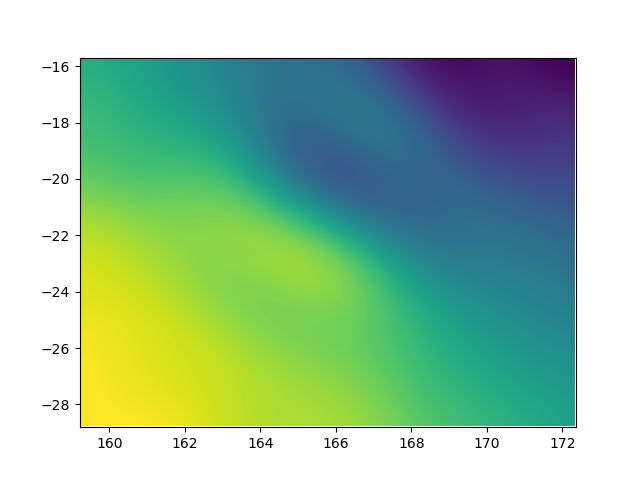

In [21]:
plt.figure()
plt.pcolormesh(ssh_bar_interpolated.nav_lon, ssh_bar_interpolated.nav_lat, ssh_bar_interpolated)
plt.show()